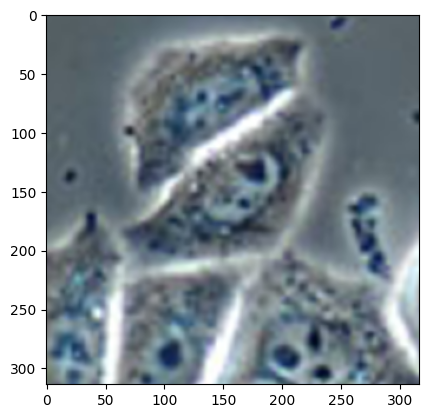

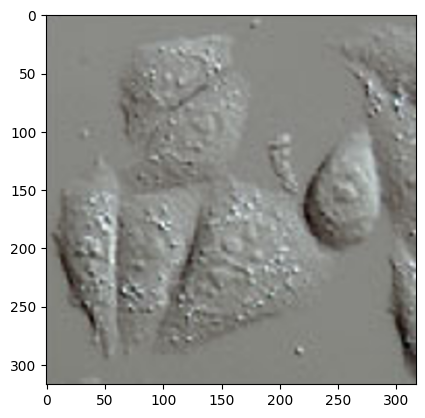

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.interpolate import interp2d

# open both images
source = cv2.imread('Source.png')
target = cv2.imread('Target.png')

# convert images from bgr to rgb
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

# show both images
plt.imshow(source)
plt.show()
plt.imshow(target)
plt.show()

In [2]:
# Selection of N points where N >= 4

srcPoints = [
    (110, 28),
    (80, 150),
    (85, 205),
    (203, 203)
]

trgPoints = [
    (89, 24),
    (71, 106),
    (75, 155),
    (157, 142)
]

In [3]:
# [1] Estimation of homography transformation matrix, h, assuming h_33=1

# initialize A and b
A = np.zeros((2 * len(srcPoints), 8))
b = np.zeros((2 * len(srcPoints), 1))

# construct A and b
for i in range(len(srcPoints)):
    srcX, srcY = srcPoints[i][0], srcPoints[i][1]
    trgX, trgY = trgPoints[i][0], trgPoints[i][1]

    A[2*i] = [srcX, srcY, 1, 0, 0, 0, -srcX*trgX, -srcY*trgX]
    A[2*i+1] = [0, 0, 0, srcX, srcY, 1, -srcX*trgY, -srcY*trgY]

    b[2*i] = trgX
    b[2*i+1] = trgY

# derive h from pseudo-inverse where h = (A.t * A)^-1 * A.t * b
first = np.linalg.pinv(np.matmul(A.T, A))
second = np.matmul(A.T, b)
h = np.matmul(first, second)

# create h_vec (9x1) for future convienience
h_vec = np.append(h, 1)
print(h_vec.shape)
print(h_vec)

# reshape h to 3x3
h = np.append(h, 1)
h = np.reshape(h, (3, 3))
print(h.shape)
print(h)

(9,)
[ 7.12566771e-01 -1.01685584e-01  1.98176746e+01  6.91065529e-02
  5.59686484e-01  2.44017845e+00  1.01162749e-03 -1.42496388e-03
  1.00000000e+00]
(3, 3)
[[ 7.12566771e-01 -1.01685584e-01  1.98176746e+01]
 [ 6.91065529e-02  5.59686484e-01  2.44017845e+00]
 [ 1.01162749e-03 -1.42496388e-03  1.00000000e+00]]


In [4]:
# [2] Estimatation of homography transformation matrix, h, without assuming h_33=1

# initialize A and b
A = np.zeros((2 * len(srcPoints), 9))
b = np.zeros((2 * len(srcPoints), 1))

# construct A
for i in range(len(srcPoints)):
    srcX, srcY = srcPoints[i][0], srcPoints[i][1]
    trgX, trgY = trgPoints[i][0], trgPoints[i][1]

    A[2*i] = [srcX, srcY, 1, 0, 0, 0, -srcX*trgX, -srcY*trgX, -trgX]
    A[2*i+1] = [0, 0, 0, srcX, srcY, 1, -srcX*trgY, -srcY*trgY, -trgY]

# derive h_eig from A*h=0 and eigen decomposition
eigenValues, eigenVectors = np.linalg.eig(np.matmul(A.T, A))
h_eig = eigenVectors[:, np.argmin(eigenValues)]
print(h_eig.shape)
print(h_eig)

(9,)
[ 3.56047238e-02 -5.08090916e-03  9.90226915e-01  3.45303769e-03
  2.79657757e-02  1.21928018e-01  5.05478502e-05 -7.12009691e-05
  4.99668588e-02]


In [5]:
# [3] Using the same A as above, solve h by singular value decomposition

# derive h_svd from A*h=0 and singular value decomposition
u, s, vh = np.linalg.svd(A)
h_svd = vh[-1]
print(h_svd.shape)
print(h_svd)

(9,)
[ 3.56047217e-02 -5.08090899e-03  9.90226911e-01  3.45303720e-03
  2.79657744e-02  1.21928051e-01  5.05478454e-05 -7.12009662e-05
  4.99668568e-02]


In [6]:
# [4] given h (h_vec), h_eig, and h_svd, compare the three

# check if h_eig is equal to h_svd
print("Is h_eig equal to h_svd?: ", np.allclose(h_eig, h_svd))
print("h_eig\t\t\th_svd")
for i in range(len(h_eig)):
    print(h_eig[i], "\t", h_svd[i])
print()

# divide h_eig and h_svd by their last element to normalize
h_eig = h_eig / h_eig[-1]
h_svd = h_svd / h_svd[-1]

# check if first 8 elements of h_eig and h_svd are equal to h_vec
print("Are the first 8 lements of h_eig equal to h_vec?: ", np.allclose(h_eig[:-1], h_vec[:-1]))
print("Are the first 8 lements of h_svd equal to h_vec?: ", np.allclose(h_svd[:-1], h_vec[:-1]))
print("h_eig\t\t\t\th_svd\t\t\t\th_vec")
for i in range(len(h_eig)):
    print(h_eig[i], "\t\t", h_svd[i], "\t\t", h_vec[i])

# I'm sorry for printing it like this but there weren't any instructions on what method to use for checking and comparing.
# There could be an % accuracy check for the values or something but I'm lazy enough to just leave it as this.
# You might want to raise your output size limit on VSCode 
# Also, the values aren't 100% equal but they're close enough to where I'll say floating point ¯\_(ツ)_/¯

Is h_eig equal to h_svd?:  True
h_eig			h_svd
0.03560472376180021 	 0.03560472173738431
-0.005080909164986298 	 -0.005080908991093412
0.990226915275151 	 0.9902269114869334
0.0034530376911156226 	 0.0034530371982634377
0.027965775735174954 	 0.02796577437696232
0.12192801805586272 	 0.12192805058396776
5.0547850164846544e-05 	 5.0547845448542517e-05
-7.120096912216359e-05 	 -7.120096623395265e-05
0.049966858807628266 	 0.049966856761374384

Are the first 8 lements of h_eig equal to h_vec?:  True
Are the first 8 lements of h_svd equal to h_vec?:  True
h_eig				h_svd				h_vec
0.7125667814916666 		 0.7125667701576867 		 0.7125667711645747
-0.10168558292903161 		 -0.10168558361311772 		 -0.10168558354585855
19.817673932386093 		 19.817674668149294 		 19.817674602541956
0.06910655929782922 		 0.06910655226431454 		 0.06910655288675116
0.5596864882550014 		 0.5596864839931368 		 0.5596864843782896
2.4401777691346167 		 2.4401785200589434 		 2.440178453369299
0.0010116275341512878 		 0.001011

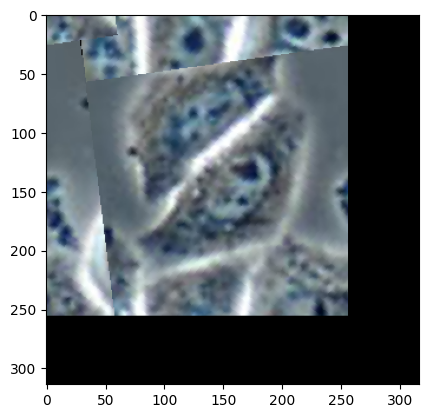

In [7]:
# [5] implement forward warping on source image using h_eig

xCoords = []
yCoords = []
pixels = []

# change h_eig, h_svd, h to 3x3
h_eig = np.reshape(h_eig, (3, 3))
h_svd = np.reshape(h_svd, (3, 3))

# initialize warped image
warped = np.zeros((source.shape[0], source.shape[1], 3), dtype=np.uint8)

# iterate through each pixel
for i in range(source.shape[0]):
    for j in range(source.shape[1]):
        x = i
        y = j
        xPrime, yPrime, toss =  (np.matmul(h, [x, y, 1]))
        currentPixelArray = source[x, y]
        xCoords.append(xPrime)
        yCoords.append(yPrime)
        pixels.append(currentPixelArray)

# normalize xPrime to be between 0 and source.shape[0]
xCoords = np.array(xCoords)
xCoords = (xCoords - np.min(xCoords)) / (np.max(xCoords) - np.min(xCoords))
xCoords *= source.shape[0]-1
xCoords = xCoords.astype(np.uint8)

# normalize yPrime to be between 0 and source.shape[1]
yCoords = np.array(yCoords)
yCoords = (yCoords - np.min(yCoords)) / (np.max(yCoords) - np.min(yCoords))
yCoords *= source.shape[1]-1
yCoords = yCoords.astype(np.uint8)

for i in range(len(xCoords)):
    warped[xCoords[i], yCoords[i]] = (pixels[i] / 255.0 * 255).astype(np.uint8)

# show warped image
plt.imshow(warped)
plt.show()

In [8]:
"""
# [6] implement backward warping

xi, yi = np.meshgrid(np.arange(0, source.shape[1]), 
                     np.arange(0, source.shape[0]))
h_inv = np.linalg.inv(h)

xx = (h_inv[0,0]*xi + h_inv[0,1]*yi + h_inv[0,2]) / (h_inv[2,0]*xi + h_inv[2,1]*yi + h_inv[2,2])
yy = (h_inv[1,0]*xi + h_inv[1,1]*yi + h_inv[1,2]) / (h_inv[2,0]*xi + h_inv[2,1]*yi + h_inv[2,2])

# divide source into channel arrays
sourceR = source[:, :, 0]
sourceG = source[:, :, 1]
sourceB = source[:, :, 2]

# interpolate each channel
interpR = interp2d(xx, yy, sourceR)(xi, yi)
interpG = interp2d(xx, yy, sourceG)(xi, yi)
interpB = interp2d(xx, yy, sourceB)(xi, yi)

# combine channels
interp = np.dstack((interpR, interpG, interpB))

# clip to [0, 255] range
interp = np.clip(interp, 0, 255).astype(np.uint8)

# show warped image
plt.imshow(interp)
plt.show()
"""

'\n# [6] implement backward warping\n\nxi, yi = np.meshgrid(np.arange(0, source.shape[1]), \n                     np.arange(0, source.shape[0]))\nh_inv = np.linalg.inv(h)\n\nxx = (h_inv[0,0]*xi + h_inv[0,1]*yi + h_inv[0,2]) / (h_inv[2,0]*xi + h_inv[2,1]*yi + h_inv[2,2])\nyy = (h_inv[1,0]*xi + h_inv[1,1]*yi + h_inv[1,2]) / (h_inv[2,0]*xi + h_inv[2,1]*yi + h_inv[2,2])\n\n# divide source into channel arrays\nsourceR = source[:, :, 0]\nsourceG = source[:, :, 1]\nsourceB = source[:, :, 2]\n\n# interpolate each channel\ninterpR = interp2d(xx, yy, sourceR)(xi, yi)\ninterpG = interp2d(xx, yy, sourceG)(xi, yi)\ninterpB = interp2d(xx, yy, sourceB)(xi, yi)\n\n# combine channels\ninterp = np.dstack((interpR, interpG, interpB))\n\n# clip to [0, 255] range\ninterp = np.clip(interp, 0, 255).astype(np.uint8)\n\n# show warped image\nplt.imshow(interp)\nplt.show()\n'